In [45]:
import numpy as np
import pandas as pd
import os
from scipy.linalg import block_diag
from scipy.optimize import minimize
from sklearn.model_selection import KFold
import itertools
import multiprocessing
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import clear_output
import time

In [46]:
file_path = './Synched_Data_GR0_22_DEN_MAXZ1_25/NEWDATA/'
file_date = ['101922', '102122', '111422', '111622', '120522', '120722', '013023', '020123', '031323', '031523', '041723', '041923', '061523']
date = file_date[0]

file_name = f'DAYUBIGR_{date}_GR0_22_DEN_032825_V2392628911.CSV'
full_path = file_path + file_name

raw_data = pd.read_csv(full_path, header=None, names=['SUBJECTID', 'TIME', 'X', 'Y', 'Z'])
clear_data = raw_data.reset_index(drop=True)
clear_data = clear_data[(clear_data["X"] <= 15) & (clear_data["Y"] <= 9) & 
                        (clear_data["X"] >= 0) & (clear_data["Y"] >= 0)].copy()
target_subject_base = "DS_STARFISH_2223_27"
subject_data = clear_data[clear_data['SUBJECTID'].str.startswith(target_subject_base)].copy()
subject_data['side'] = subject_data['SUBJECTID'].str.extract(r'(\d+[LR])$')[0].str[-1].map({'L': 'left', 'R': 'right'})


In [47]:
print(subject_data[0:5])

                   SUBJECTID                     TIME          X         Y  \
166592  DS_STARFISH_2223_27L  2022-10-19 09:40:01.411   9.747519  6.287574   
166593  DS_STARFISH_2223_27R  2022-10-19 09:40:02.973   9.343626  6.803862   
166594  DS_STARFISH_2223_27L  2022-10-19 09:40:03.411  10.313702  5.339942   
166595  DS_STARFISH_2223_27R  2022-10-19 09:40:03.973   8.989950  7.036655   
166596  DS_STARFISH_2223_27L  2022-10-19 09:40:04.411  10.313702  5.339942   

               Z   side  
166592  1.148477   left  
166593  0.906106  right  
166594  0.757258   left  
166595  1.056961  right  
166596  0.757258   left  


In [48]:
def create_jupyter_animation(subject_data):
    
    data_sorted = subject_data.sort_values('TIME').reset_index(drop=True)
    step = 1
    
    for i in range(0, len(data_sorted), step):
        clear_output(wait=True)
        
        current_data = data_sorted.iloc[:i+1]
        
        plt.figure(figsize=(14, 10))
        left_data = current_data[current_data['side'] == 'left']
        right_data = current_data[current_data['side'] == 'right']
        
        if len(left_data) > 0:
            plt.scatter(left_data['X'], left_data['Y'], c='red', s=50, alpha=0.5, label='Left Side')
        
        if len(right_data) > 0:
            plt.scatter(right_data['X'], right_data['Y'], c='blue', s=50, alpha=0.5, label='Right Side')
        
        if i < len(data_sorted):
            current_point = data_sorted.iloc[i]
            color = 'red' if current_point['side'] == 'left' else 'blue'
            plt.scatter(current_point['X'], current_point['Y'], c=color, s=100, alpha=1.0, 
                       edgecolors='black', linewidth=2, marker='o')
        
        plt.xlim(0, 15)
        plt.ylim(0, 9)
        plt.xlabel('X Position')
        plt.ylabel('Y Position')
        plt.title(f'Starfish Movement - Point {i+1}/{len(data_sorted)}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.show()
        time.sleep(0.1)

create_jupyter_animation(subject_data)

KeyboardInterrupt: 

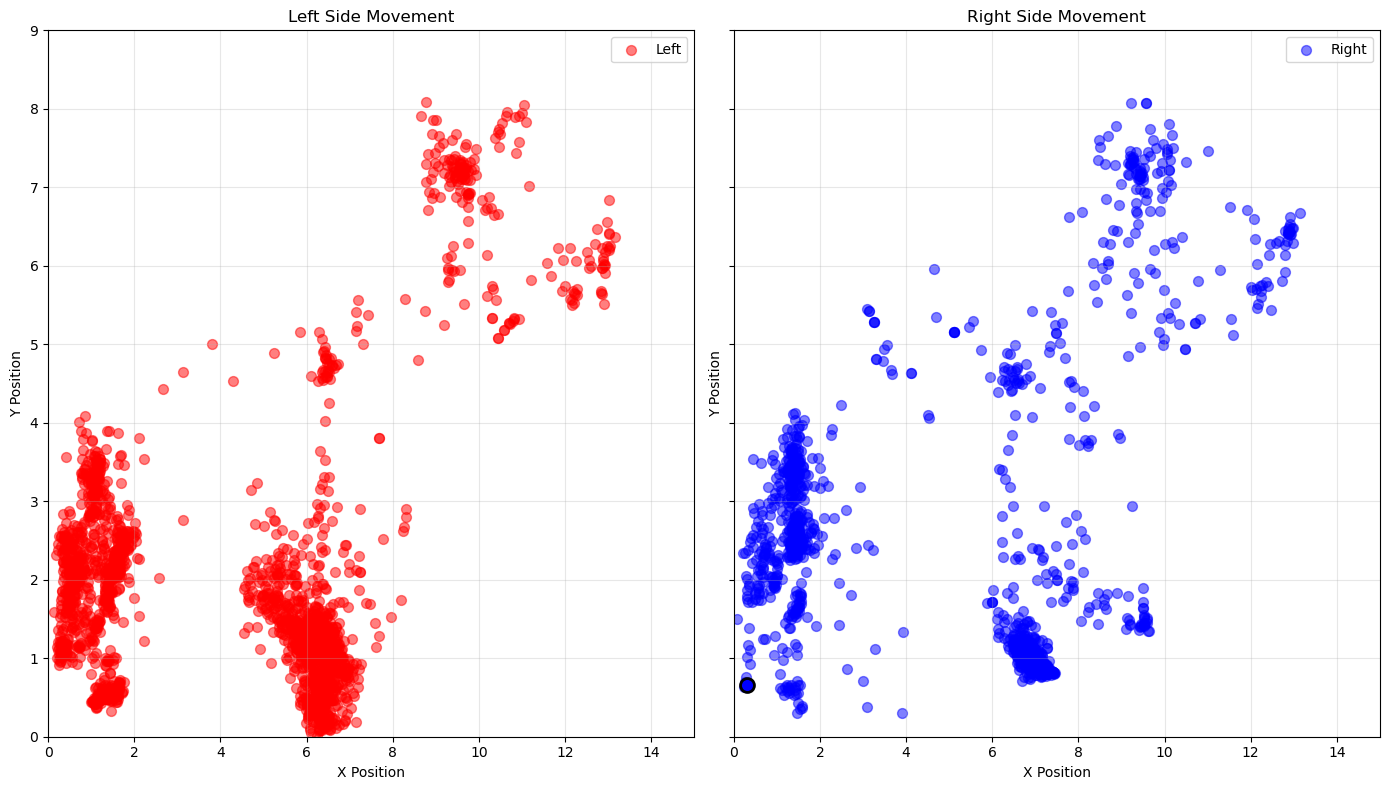

KeyboardInterrupt: 

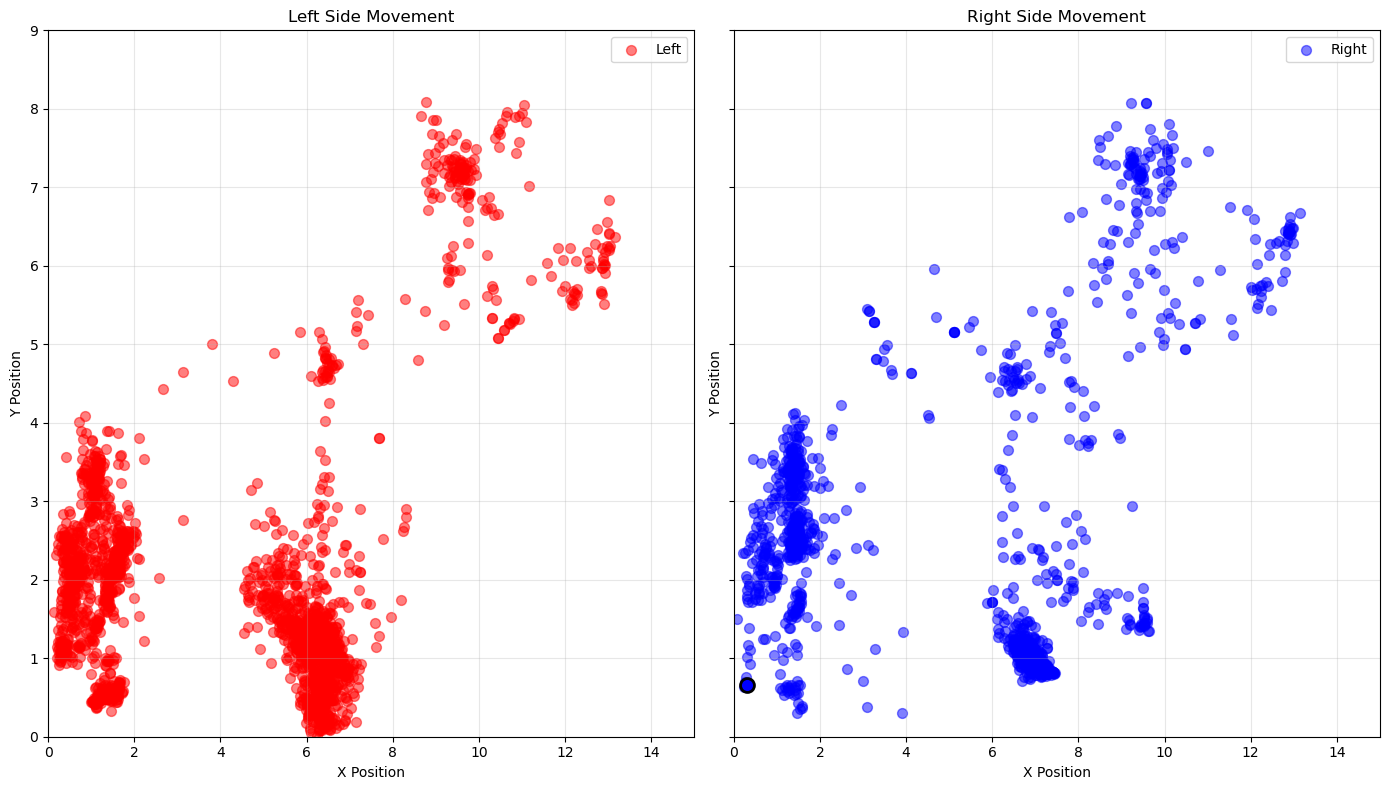

In [64]:
def separate_animation(subject_data):
    import matplotlib.pyplot as plt
    from IPython.display import clear_output, display
    import time

    data_sorted = subject_data.sort_values('TIME').reset_index(drop=True)
    step = 1

    # Set up plot
    fig, axs = plt.subplots(1, 2, figsize=(14, 8), sharex=True, sharey=True)

    for i in range(0, len(data_sorted), step):
        clear_output(wait=True)

        # Clear previous plots
        for ax in axs:
            ax.clear()
            ax.set_xlim(0, 15)
            ax.set_ylim(0, 9)
            ax.set_xlabel('X Position')
            ax.set_ylabel('Y Position')
            ax.grid(True, alpha=0.3)

        current_data = data_sorted.iloc[:i+1]

        # Left
        left_data = current_data[current_data['side'] == 'left']
        axs[0].scatter(left_data['X'], left_data['Y'], c='red', s=50, alpha=0.5, label='Left')
        if not current_data.empty and current_data.iloc[-1]['side'] == 'left':
            point = current_data.iloc[-1]
            axs[0].scatter(point['X'], point['Y'], c='red', s=100, edgecolors='black', linewidth=2, marker='o')
        axs[0].legend()
        axs[0].set_title(f'Left Side Movement')

        # Right
        right_data = current_data[current_data['side'] == 'right']
        axs[1].scatter(right_data['X'], right_data['Y'], c='blue', s=50, alpha=0.5, label='Right')
        if not current_data.empty and current_data.iloc[-1]['side'] == 'right':
            point = current_data.iloc[-1]
            axs[1].scatter(point['X'], point['Y'], c='blue', s=100, edgecolors='black', linewidth=2, marker='o')
        axs[1].legend()
        axs[1].set_title(f'Right Side Movement')

        plt.tight_layout()
        display(fig)
        time.sleep(0.1)

separate_animation(subject_data) 